<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/ODE_Regression_with_Haiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Important links:
https://github.com/deepmind/dm-haiku/blob/main/examples/mnist.py
https://notebook.community/deepmind/dm-haiku/examples/haiku_lstms

In [2]:
!pip install git+https://github.com/deepmind/dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-nfghdrh6
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-nfghdrh6
  Resolved https://github.com/deepmind/dm-haiku to commit f6439a1a234f1c46f0d515ade42de6f47553e7ef
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.10.dev0-py3-none-any.whl size=360287 sha256=a91bd5d337d992e9b3397694885d822c93ed0e375ebc8c76beaab575b2f489f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ptmxl8dv/wheels/b1/df/f1/a357fa8f00c36052bdae1e1fd363650c0bd1e8c3959487b6fb
Successfully built dm-haiku


In [368]:
from typing import Iterator, NamedTuple

import pdb
from absl import app
import haiku as hk
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import value_and_grad, jit, vmap, grad, random, make_jaxpr
from jax.numpy import pi, sin, cos
from jax.experimental.ode import odeint
from jax.config import config
import scipy as sci
import time
import numpy as np
import optax
from sklearn.model_selection import train_test_split

config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
config.update("jax_disable_jit", False)

In [369]:
# Create our random keys, for data generation.
key, subkey = random.split(random.PRNGKey(int(time.time())))
gradient_updates = 15000
datapoints = 1024
batch_size = 8

# Make a function to create our datapoints.
def generate_data(t):
  return t + sin(t) + 0.3 * random.normal(subkey, shape=(datapoints,))

# Generate inputs and targets
x_truth = random.uniform(key, minval=0, maxval=10, shape=(datapoints,))
y_truth = generate_data(x_truth)

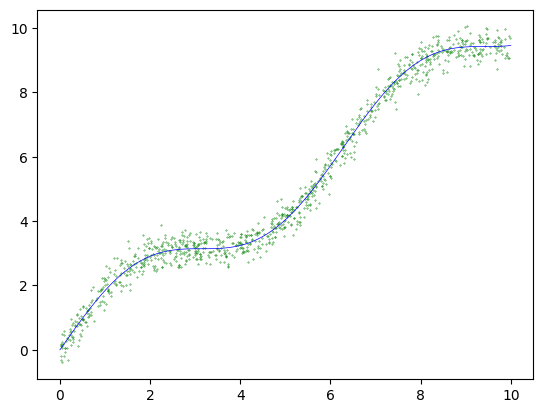

In [370]:
# Graph targets against actual curve.
plt.scatter(x_truth, y_truth, s=0.1, color='green')
fine_inputs = jnp.reshape(jnp.linspace(0, 10, 1000), (1000, 1))
plt.plot(fine_inputs, fine_inputs + sin(fine_inputs), lw=0.5, color='blue')

In [371]:
# When integrating, we need an initial condition. Normalising makes (0, 0) no longer in the line so instead we can use (x_init, y_init) as the initial condition.

x_mean = jnp.mean(x_truth)
x_std = jnp.std(x_truth)
y_mean = jnp.mean(y_truth)
y_std = jnp.std(y_truth)

x_truth = (x_truth - x_mean) / x_std
y_truth = (y_truth - y_mean) / y_std

# When integrating, we need an initial condition. Normalising makes (0, 0) no longer in the line so instead we can use (0, y_centre) as the initial condition.
x = - 0.5
x_init = (x - x_mean) / x_std
y_init = (sin(x) + x - y_mean)/ y_std

# Split the data:
x_train, x_test, y_train, y_test = train_test_split(x_truth, y_truth, random_state=42)

# Data needs to be in this format to go into the model.
x_train = x_train.reshape(len(x_train),1)
x_test = x_test.reshape(len(x_test),1)

In [372]:
# Define our dataset class. This allows us to batch our data when training.
class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""
  # Initialise our dataset class. It needs the full x and y values and a batch size to be initialised.
  def __init__(self, x: jnp.array, y: jnp.array, batch_size: int):
    self._x = x
    self._y = y
    self._batch_size = batch_size
    self._length = self._x.shape[0]
    # The id stores where the next datapoint should be taken from, so when initialised it should be 0.
    self._idx = 0
    if self._length % batch_size != 0:
      msg = 'dataset size {} must be divisible by batch_size {}.'
      raise ValueError(msg.format(self._length, batch_size))

  # This is the function that gives us our next batch of data.
  def __next__(self):
    # Select the first and last datapoints in the batch. First will be the current value of the ID
    start = self._idx
    end = start + self._batch_size
    # Select our data.
    x, y = self._x[start:end], self._y[start:end]
    # This resets us back to 0 once we reach the end of our data.
    if end >= self._length:
      end = end % self._length
      # assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end
    return x, y

In [373]:
# Now that we have defined our dataset class, we can make our datasets:
train_dataset = Dataset(x_train, y_train, batch_size)
eval_dataset = Dataset(x_test, y_test, batch_size)

In [374]:
# Define a batch of data.
class Batch(NamedTuple):
  input: np.ndarray
  output: np.ndarray

# Define a training state, telling us what parameters we have and the state of the optimizer.
class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

In [375]:
# Define the neural network.
def FeedForward(x):
  mlp = hk.Sequential([
      hk.Linear(10), jax.nn.relu,
      hk.Linear(10), jax.nn.relu,
      hk.Linear(1),
  ])
  return mlp(x)

# Define our network and optimiser.
network = hk.without_apply_rng(hk.transform(FeedForward))
optimiser = optax.adam(1e-3)

In [376]:
# Define our mean squared error loss.
# The jits are hashed out because if it is jitted it does not print the actual data, it just prints the datatype, which does not help when debugging.
@jit
def dy_dx(y, x, weights):
  return network.apply(weights, jnp.array([x]))

@jit
def MeanSquaredErrorLoss(weights, batch):
  # Create the predictions of the y values.
  # This adds our initial value, 0, for when we solve the ode.

  xsteps = batch[0].flatten()
  p = xsteps.argsort()
  xsteps = xsteps[p]
  ybatch = batch[1][p]
  xsteps = jnp.insert(xsteps, 0, x_init)
  #print("ybatch = ", ybatch)
  #print("batch[1] = ", batch[1])


  preds = odeint(dy_dx, y_init, xsteps, weights)

  # This removes the fact that it is an array of arrays. Also, we do not need the initial value of 0.
  preds = preds.squeeze()[1:]

  # These are temporary, for debugging.
  # print("WEIGHTS = ", weights)
  # print("XSTEPS = ", xsteps)
  # print("PREDS = ", preds)
  #print("BATCH[1] = ", batch[1])
  # print("OUTPUT = ", jnp.power(batch[1] - preds, 2).mean())
  return jnp.power(ybatch - preds, 2).mean()

In [377]:
@jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  # This is how we define our stochastic gradient descent.

  # Find grads of loss w.r.t parameters, on this batch of the data
  #print(make_jaxpr(jax.grad(MeanSquaredErrorLoss))(state.params, batch))

  grads = jax.grad(MeanSquaredErrorLoss)(state.params, batch)
  #print("GRADS = ", grads)

  # Get the updates and the new optimser state from this.
  updates, opt_state = optimiser.update(grads, state.opt_state)
  # Apply the updates to the parameters.
  params = optax.apply_updates(state.params, updates)

  #return the training state with the new parameters and the optimiser.
  return TrainingState(params, opt_state)


In [378]:
#Initialising the parameters randomly.
rng = jax.random.PRNGKey(12)
initial_params = network.init(rng, x_train[:1])

# Initialise the optimiser and the define the state.
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

# Print the structure of the network.
print("Weights Type : {}\n".format(type(initial_params)))

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape,initial_params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

linear
Weights : (1, 10), Biases : (10,)

linear_1
Weights : (10, 10), Biases : (10,)

linear_2
Weights : (10, 1), Biases : (1,)



Step 0: train loss 3.5967017056680683, eval loss 1.5506028932295255
Step 1000: train loss 0.04915656743717048, eval loss 0.08549886772696319
Step 2000: train loss 0.0655236358089537, eval loss 0.04132824152742655
Step 3000: train loss 0.02683779562478021, eval loss 0.0919782777044074
Step 4000: train loss 0.020781283263962322, eval loss 0.038848003220344283
Step 5000: train loss 0.012653771123769145, eval loss 0.03341964217213226
Step 6000: train loss 0.006836788373316123, eval loss 0.032325984321118675
Step 7000: train loss 0.020891462729722098, eval loss 0.005295066823213188
Step 8000: train loss 0.005856077916350963, eval loss 0.012901368675903264
Step 9000: train loss 0.010137477010193411, eval loss 0.02615830855664706
Step 10000: train loss 0.009361184818020181, eval loss 0.014832806761979466
Step 11000: train loss 0.017802882232781342, eval loss 0.008634437055948822
Step 12000: train loss 0.008673054853444322, eval loss 0.006061252415356742
Step 13000: train loss 0.00793992028683

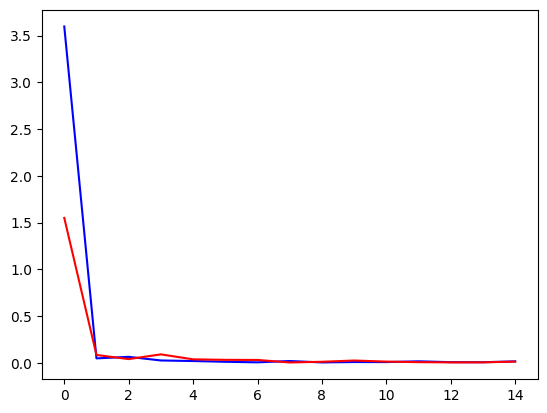

In [379]:
# Training & evaluation loop.
train_loss_list = []
val_loss_list = []
for step in range(gradient_updates):
  # Do stochastic gradient descent on a batch of training examples.
  state = update(state, next(train_dataset))

  # This is temporary, for debugging.
  # if step == 1:
  #   break
  # Print the training and evaluation loss every 1000 time steps.
  if step % 1000 == 0:
    train_loss_list.append(MeanSquaredErrorLoss(state.params, next(train_dataset)))
    val_loss_list.append(MeanSquaredErrorLoss(state.params, next(eval_dataset)))
    print("Step {}: train loss {}, eval loss {}".format(step, train_loss_list[-1], val_loss_list[-1]))

plt.plot(train_loss_list, color="b")
plt.plot(val_loss_list, color="red")

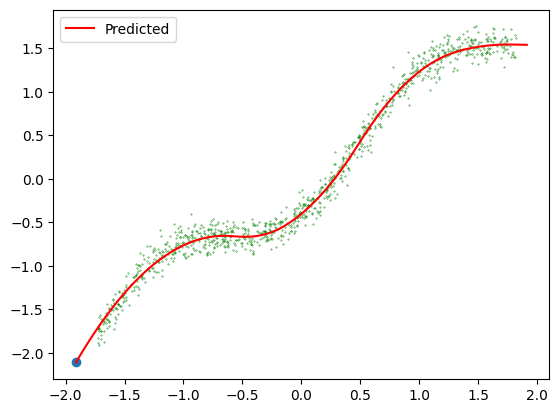

In [381]:
 # Graph our prediction against the actual curve and the testing data

plt.scatter(x_truth, y_truth, s=0.1, color='green')
fine_inputs = jnp.reshape(jnp.linspace(x_init, -x_init, 1000), (1000, 1))

preds = odeint(dy_dx, y_init, fine_inputs.flatten(), state.params)
plt.plot(x_init, y_init, "o")
plt.plot(fine_inputs, preds, color='red', label="Predicted")
plt.legend()